# Lesson 7 - Support Vector Machines (SVM)

## Author - Lukas Fiorio

## Instructions

- Read data. Split into train/validate/test. Pre-process.
- Dichotimize the target
- Tune hyper parameters
- Evaluate Accuracy (recall, precision, F1)
- Summarize findings and make a recommendation

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from itertools import product
from sklearn import svm

In [3]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

### Load data

- note: headers in first row of csv

In [4]:
# read file into df
file = "https://library.startlearninglabs.uw.edu/DATASCI420/2019/Datasets/Abalone.csv"
abalone_df = pd.read_csv(file, header = 0)

Based on preview of the data, looks like all features are numeric, except for `Sex`.  The target, `Rings` will need to be dichotomized (0-10, 11+)

In [5]:
abalone_df.head() # preview data

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


We get confirmation here of numeric columns (other than `Sex`).  We also see no missing values.

In [5]:
abalone_df.info() # examine data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole Weight    4177 non-null   float64
 5   Shucked Weight  4177 non-null   float64
 6   Viscera Weight  4177 non-null   float64
 7   Shell Weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


### Split the data

Before doing any preprocessing, let's split our data (columns) into features (`X`) and target (`y`). From there, we'll split (observations) into train-validate-test.

In [6]:
# specify target
target = 'Rings'

# copy df features and drop target
X = abalone_df.copy().drop([target], axis = 1)

# store target separately
y = abalone_df[target].copy()

Now let's split the data into train-validate-test sets (80-10-10).  Create a validation set for evaluation of hyper parameters.

- First split into train-test @ 90-10.
- Then split train into train-valid @ 80-10 *(0.90 * (1/9) = 0.1)*

In [7]:
# set the random state
random_state = 0

In [8]:
# split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = random_state)

# split train into train-validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = (1/9), random_state = random_state)

Reset index on each of our datasets to avoid issues with joining later on (during pre-processing)

In [9]:
# reset index to avoid issues with joining later on
X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_valid = y_valid.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

Check the # of observations in each datset. Indeed, we've gotten an 80-10-10 split.

In [10]:
# verify size of train/valid/test splits
print(len(X_train), '- # obs: training')
print(len(X_valid), ' - # obs: validation')
print(len(X_test), ' - # obs: test')

3341 - # obs: training
418  - # obs: validation
418  - # obs: test


### Preprocessing

In this section, we'll apply onehot encoding to our categorical columns (namely, `Sex`) and standardize our continuous columns.  It's important to do our train-validate-test split *before* doing this pre-processing so that we can fit our encoders/standardizers on the **training** data.

If we wait to split until *after* we've encoded/standardized our data, then the test data has leaked into our training set (it partially influences the distribution).

First we'll designate which columns need onehot encoding vs standardization.

In [11]:
# categorical columns (onehot)
onehot_cols = X_train.select_dtypes('object').columns.to_list()

# numeric columns (z-scale)
scale_cols = X_train.select_dtypes(['float', 'int']).columns.to_list()

#### onehot encoding

Now we will fit one hot encoding based on our training data and then apply it to our train, validate, and test datasets.

Note that if we expect to see new value categories in the future (in production or in our test set) that using `drop = first` won't quite work for us (that setting can't handle when unknown categories show up in new datasets).

- `drop = 'first'` drops the first class from each column (removes linear dependence).

In [12]:
# initialize class and fit our data (drop linearly dependent columns)
onehot = OneHotEncoder(sparse = False, drop = 'first') # initialize one-hot-encoder
onehot.fit(X_train[onehot_cols])

# properly name columns
onehot_names = onehot.get_feature_names(onehot_cols).astype(str)
onehot_names = np.char.replace(onehot_names, ".", "_")

# onehot.transform to create encoded variables
# note: wrap in pd.dataframe (default returns np array)
X_train_onehot = pd.DataFrame(onehot.transform(X_train[onehot_cols]), columns = onehot_names)
X_valid_onehot = pd.DataFrame(onehot.transform(X_valid[onehot_cols]), columns = onehot_names)
X_test_onehot = pd.DataFrame(onehot.transform(X_test[onehot_cols]), columns = onehot_names)

Preview the onehot enconded columns.  We see two columns, which mean there are *three* possible values (we dropped the "first" linearly dependent value).

Consulting the documentation shows that `Sex` takes the following values:
- `F`: Female
- `M`: Male
- `I`: Infant

In [13]:
# preview onehot encoded df
X_test_onehot.head()

,Sex_I,Sex_M
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


#### standardizing continous columns

Fit the `znormalizer` on the training data and then apply it to the validation and test set.  As with onehot encoding, this is to prevent leakage from the test/validation set into the training set (where we fit our model).

In [14]:
# initialize and fit z-transform based on TRAIN data
znormalizer = StandardScaler()
znormalizer.fit(X_train[scale_cols])

# apply fitted transformation to train, validate, and test data
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[scale_cols]), columns = scale_cols)
X_valid_norm = pd.DataFrame(znormalizer.transform(X_valid[scale_cols]), columns = scale_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[scale_cols]), columns = scale_cols)

#### Combine pre-preprocessed features into "featurized" datasets

Now join the onehot encoded and normalized features back together to make our featurized datsets.

In [15]:
# prepped training dataset
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_train_featurized[scale_cols] = X_train_norm # add znormalized columns

# prepped validation dataset
X_valid_featurized = X_valid_onehot # add one-hot-encoded columns
X_valid_featurized[scale_cols] = X_valid_norm # add znormalized columns

# prepped test dataset
X_test_featurized = X_test_onehot # add one-hot-encoded columns
X_test_featurized[scale_cols] = X_test_norm # add znormalized columns

Double check that observation counts still line up and no nulls introduced.  Verification shows no issues.

In [16]:
# verify size of featurized datasets
print(len(X_train_featurized), '- # obs: training')
print(len(X_valid_featurized), ' - # obs: validation')
print(len(X_test_featurized), ' - # obs: test')

3341 - # obs: training
418  - # obs: validation
418  - # obs: test


In [17]:
# check for data types & nulls
X_train_featurized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3341 entries, 0 to 3340
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex_I           3341 non-null   float64
 1   Sex_M           3341 non-null   float64
 2   Length          3341 non-null   float64
 3   Diameter        3341 non-null   float64
 4   Height          3341 non-null   float64
 5   Whole Weight    3341 non-null   float64
 6   Shucked Weight  3341 non-null   float64
 7   Viscera Weight  3341 non-null   float64
 8   Shell Weight    3341 non-null   float64
dtypes: float64(9)
memory usage: 235.0 KB


#### dichotomize target

Finally, let's convert our target `Rings` into a binary variable.  Our cutpoint is at `Rings = 11` and we'll label our output as `[-1, 1]` since we will be using SVM for this model.

In [18]:
# pd.cut to split at <=10, >10
y_train = pd.cut(y_train, [-np.inf, 10, np.inf], labels=[-1, 1])
y_valid = pd.cut(y_valid, [-np.inf, 10, np.inf], labels=[-1, 1])
y_test = pd.cut(y_test, [-np.inf, 10, np.inf], labels=[-1, 1])

Checking class imbalance on our train data, we see that our data are a bit biased toward fish with fewer than 11 rings (`target = -1`). About 1,100 rows (~34%) have 11+ rings.

In [19]:
print("{:.2%}".format((y_train==1).mean()), 'of values')
print(y_train.value_counts())

34.18% of values
-1    2199
 1    1142
Name: Rings, dtype: int64


### Explore the training data a bit

Function to loop through and distribution count plots bsaed on df & list of columns.

In [20]:
def dist_plots(df, col_list, n_cols):
    
    # deduce nbr of rows needed for plot
    n_rows = math.ceil(len(col_list) / n_cols)

    # set figure, axis properties
    fig, ax = plt.subplots(ncols = n_cols, nrows = n_rows)
    fig.set_size_inches(16, 4 * n_rows)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    # loop through each column & plot
    for i, col in enumerate(col_list):
        
        # compute row, col index
        i_row = math.floor(i/n_cols)
        i_col = i % n_cols
        
        # make plots
        sns.distplot(a = df[col], ax = ax[i_row][i_col]); # check dist of target (continous)
        ax[i_row][i_col].title.set_text('Distribution of Abalone ' + col);

For better interpretability, we'll loop through the continuous columns in the *unscaled* training set and visually inspect their distributions.

- We notice that `Length` and `Diameter` have long left tails, while `Whole Weight`, `Shucked Weight`, `Viscera Weight`, `Shell Weight` have long right tails.
- `Height` appears to be centered, although with very small tails.

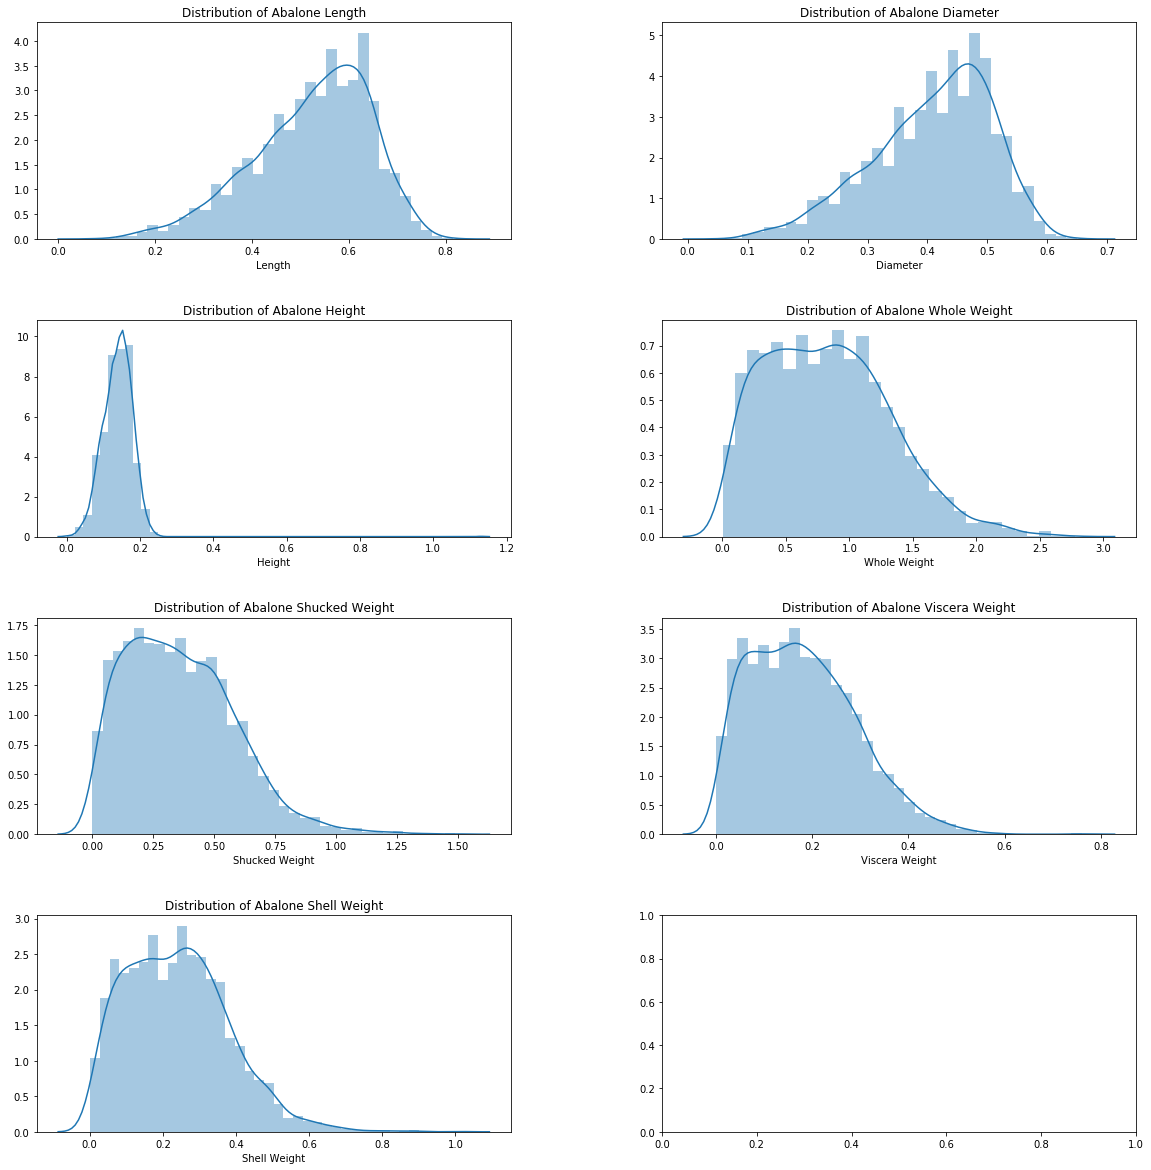

In [21]:
num_cols = X_train.select_dtypes(['float', 'int']).columns.to_list()
dist_plots(X_train, num_cols, 2)

Now let's examine the correlation between each of our features and the target.  For this, we'll use our featurized (standardized) training data.

We'll plot correlation between each feature and the target variable, sorted by absolute value.

- First calculate and sort correlations
- Then Plot tornado chart

We see most of the features have a fairly moderate level of correlation with the target (0.3 to 0.5), other than `Sex_M` which has relatively low correlation with the target.

In [22]:
# calculate correlations
target_corr = X_train_featurized.apply(lambda x: x.corr(y_train))

# sort series by abs val
target_corr = target_corr.reindex(
    target_corr.abs().sort_values(ascending = False).index
    )

Display plot of correlations.

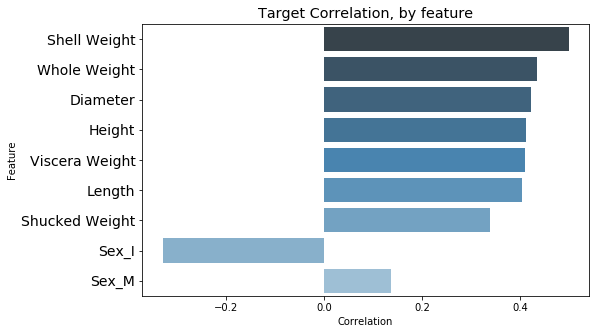

In [23]:
# index contains series values
y_labels = target_corr.index

# set fig axis properies
fig, ax = plt.subplots(figsize=(8, 5))
ax.title.set_text('Target Correlation, by feature');
ax.title.set_size('x-large');
ax.set(xlabel='Correlation', ylabel='Feature');
ax.set_yticklabels(y_labels, fontsize=14);

# plot chart
sns.barplot(x=target_corr, y=y_labels, palette="Blues_d", ax = ax);

Now let's examine the correlation *between* features.

- `Sex_I` and `Sex_M` features are moderately correlated with the other features (and themselves)
- `Height` is pretty highly correlated with the other non-gender features (0.7 - 0.8)
- All of the features are *extremely* highly correlated with each other (> 0.9).

Models that require assumptions of independently distributed (IID) features would not perform well with these features (as they are).  Unfortunately, SVM does have an IID assumption built in, so our model will suffer a bit as a result.

In practice it would be better to perform additional processing steps to remove dependence between features.

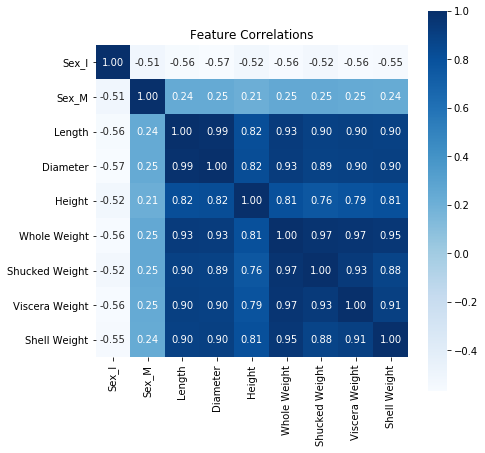

In [24]:
# calc correlations across features
corr = X_train_featurized.corr()

# plot correlations
fig, ax = plt.subplots(figsize=(7, 7));
ax.title.set_text('Feature Correlations');
sns.heatmap(corr, square = True, cmap = 'Blues', fmt = '.2f', ax = ax, annot = True);

## Fit an SVM Classifier

Create array of hyperparameter dictionaries.  Rather than specify each combination individually, crossjoin the sets of hyper parameters we would like to try.

We'll specify the following params:

- `kernel`: transformation function to fit to. Try linear, polynomial, and radial basis
- `degree`: polynomial degree to be used in the 'poly' kernel.
- `C`: L2 regularization penalty
- `gamma`: coefficient for 'poly' and 'rbf kernel
    - Note: `gamma = 'auto'` uses 1/nbr_features. `gamma = 'scale'` uses 1/(nbr_features * Var(X))

*NB - code source for carteisan product:*
- [stackoverflow: Cartesian product of dictionaries](https://stackoverflow.com/questions/15211568/combine-python-dictionary-permutations-into-list-of-dictionaries)

In [27]:
# designate hyper param combinations to attempt
hyper_space = {'kernel': ['linear', 'poly', 'rbf'], 
               'degree': [2, 3],
               'C': [5, 10, 15], 
               'gamma': ['scale', 'auto', 1]}

# crossjoin (cartesian product) to create array of dicts
hypers = [dict(zip(hyper_space, x)) for x in product(*hyper_space.values())]

# model cnt
print('# of hyper param combinations to try:', len(hypers))

# of hyper param combinations to try: 54


#### Tune model

Now we'll loop through each set of hyper parameters, fitting on the train data and making predictions on the validation data. With a 3x2x3x3 tune-grid we'll be testing out 54 models.

When we initialize the SVM classifier, we'll specify our `random_state` for replicability.

In each loop, we'll store the results and keep the model with the highest accuracy on the validation set.  

**In total this should take about 5 minutes to run.**

Also note that higher `gamma` values tend to be *much* more computationally expensive (at least in this model).  In a different environemnt, we would tune `gamma` across a broader range, but it proved too computationally intensive for this exercise.

In [28]:
# create empty df to store model results
svmc_results = pd.DataFrame(columns=['kernel', 'degree', 'C', 'gamma', 'accuracy'])

# loop through each set of hyper parameters
for hyper in hypers:

    # initialize svm classifier (** to load dict as args)
    svmc = svm.SVC(random_state = 99, **hyper)
    
    # fit classifier on train set
    svmc.fit(X_train_featurized, y_train)
    
    # make predictions on validation set (and calculate accuracy)
    y_valid_hat = svmc.predict(X_valid_featurized)
    accuracy = accuracy_score(y_valid, y_valid_hat)
    
    # store results in df
    svmc_results = svmc_results.append(pd.DataFrame({
        'kernel': hyper['kernel'], 
        'degree': hyper['degree'],
        'C': hyper['C'],
        'gamma': hyper['gamma'],
        'accuracy': [accuracy]
    }))

Quick check for null values in our results df shows none (good!).

In [29]:
svmc_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 0
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   kernel    54 non-null     object 
 1   degree    54 non-null     object 
 2   C         54 non-null     object 
 3   gamma     54 non-null     object 
 4   accuracy  54 non-null     float64
dtypes: float64(1), object(4)
memory usage: 2.5+ KB


#### Visualize the results from hyper parameter tuning.

- In general, `kernel` appears to have the biggest impact on accuracy, with the radial basis kernel performing best (followed by linear).
- Higher regularization seemed to improve accuracy on the validation set, while the gamma param varied based on other hyper parameter combinations.

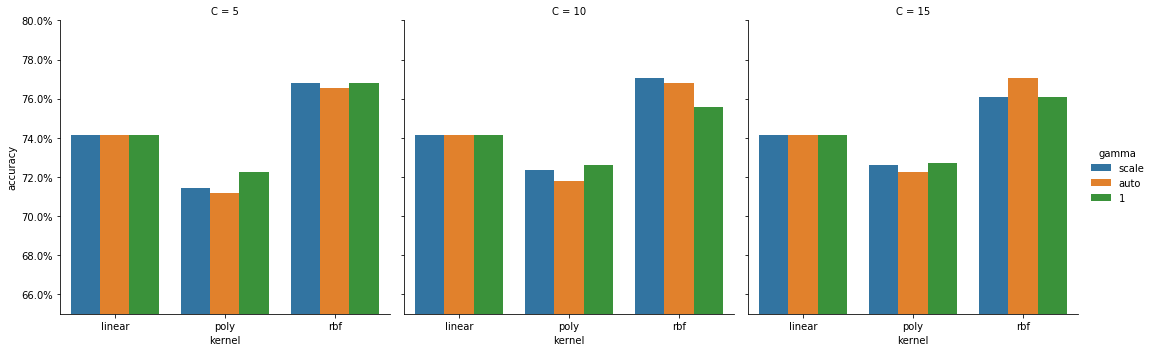

In [30]:
# specify axis
ax = sns.catplot(data = svmc_results, 
                 x = 'kernel', 
                 hue = 'gamma', 
                 col = 'C',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.65, 0.80)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

Specifically for the `'poly'` kernel, let's also visualize accuracy based on the degree of the kernel (this param has no effect on the other kernel functions).

We don't see *much* difference between `degree = 2` and `degree = 3`, but to the extent there is... 

- `degree = 2` appears to perform a bit better for *low* regularization penalties (`C =  5`)
- `degree = 3` appears to perform a bit better for *high* regularization penalties (`C = 15`)

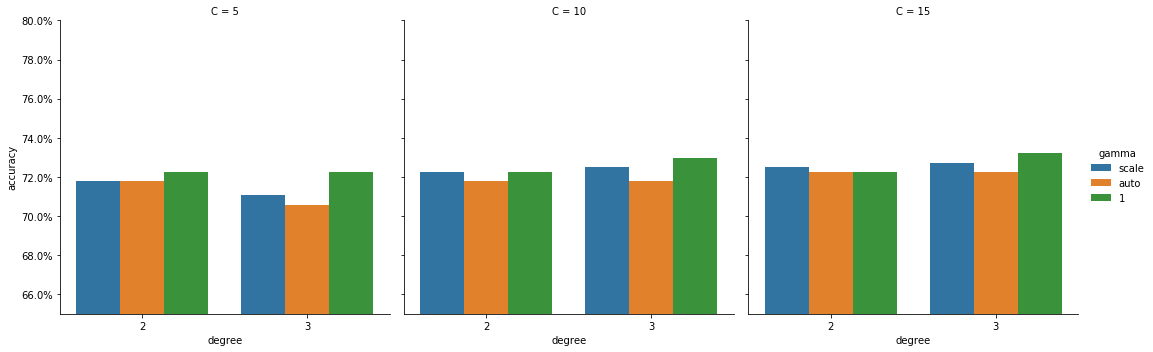

In [31]:
# specify axis
ax = sns.catplot(data = svmc_results[svmc_results['kernel']=='poly'], 
                 x = 'degree', 
                 hue = 'gamma', 
                 col = 'C',
                 y = 'accuracy', 
                 kind = 'bar',
                 ci = None);

# y axis limits
plt.ylim(0.65, 0.80)

# loop thru subplots & format axis as percentage
from  matplotlib.ticker import PercentFormatter
for subplot in ax.axes.flat:
    subplot.yaxis.set_major_formatter(PercentFormatter(1))

#### Best Model

Our winning model, did indeed use the `rbf` kernel function.  The regularization penalty, `C`, and kernel coefficient, `gamma`, were 10 and 'scale' respectively.

Our overall accuracy was 77.0% on the validation data.  Honestly, that's a bit lower than we'd like, and maybe in part due to features that are highly correlated with one another.

Not shown here, but a quick check on the `sigmoid` kernel also showed poor performance, so `rbf` was still the best kernel for us here.

*Recall that `gamma = 'scale'` uses a coefficient = 1/(nbr_features * Var(X))*

In [32]:
# winning model
svmc_results.nlargest(1, ['accuracy']) 

,kernel,degree,C,gamma,accuracy
0,rbf,2,10,scale,0.770335


We'll re-train one last time to keep our best model from above.  Since we're using the `rbf` kernel, we can drop the `degree` parameter.

In [33]:
# initalize w hyper params from best model
svmc = svm.SVC(random_state = 99,
               kernel = 'rbf',
               C = 10,
               gamma = 'scale'
              )

# fit model
svmc.fit(X_train_featurized, y_train)

SVC(C=10, random_state=99)

In preparation for evaluation on Test set, we'll define functions to clearly present the following:

- accuracy metrics (f1, precision, recall, etc)
- confusion matrix

In [34]:
def accuracy_report(y, y_hat):
    # store accuracy metrics (f1, precision, recall, accuracy, + full report)
    f1 = f1_score(y, y_hat, pos_label = 1)
    precision = precision_score(y, y_hat, pos_label = 1)
    recall = recall_score(y, y_hat, pos_label = 1)
    accuracy = accuracy_score(y, y_hat)
    class_rpt = classification_report(y, y_hat, zero_division = 0)
    
    # print accuracy measures
    print("f1: ", round(f1, 4))
    print("precision: ", round(precision, 4))
    print("recall: ", round(recall, 4))
    print("accuracy: ", round(accuracy, 4))
    print("==================================")
    print(class_rpt)

In [35]:
def format_cm(y, y_hat, title, labels, norm):
    
    # store (normalized) confusion matrix
    cm = np.round(confusion_matrix(y, y_hat, normalize = norm), 3)

    # configure confusion matrix plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # show plot and confusion matrix
    plt.show()
    print(cm)

#### Test Accuracy

First we'll make predictions using our best model (and store in `y_test_hat`)

Then we'll evaluate accuracy and examine the confusion matrix.

In [36]:
# make predictions on the test set
y_test_hat = svmc.predict(X_test_featurized)

We see accuracy on the test set is slightly higher than on the validation set (79.2% vs 77.0%).  This *can* happen and is an indicator that our model does not appear to have overfit the data.

We see precision at 0.79 (including for the negative class) and recall at 0.60 (although much higher, 0.91, for the negative class).

Without having handled the modest class imbalance we noticed earlier (about one-third positive cases), we see the model prioritized accuracy on the negative class (as shown by the higher recall on the negative class).

In [37]:
# accuracy metrics
accuracy_report(y_test, y_test_hat)

f1:  0.6813
precision:  0.7949
recall:  0.5962
accuracy:  0.7919
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85       262
           1       0.79      0.60      0.68       156

    accuracy                           0.79       418
   macro avg       0.79      0.75      0.76       418
weighted avg       0.79      0.79      0.78       418



The confusion matrix shows very similar precision (~79%) acorss classes, as noted above.

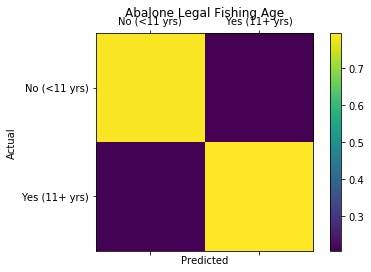

[[0.791 0.205]
 [0.209 0.795]]


In [38]:
# confusion matrix
format_cm(y_test, y_test_hat, "Abalone Legal Fishing Age", ["No (<11 yrs)", "Yes (11+ yrs)"], "pred")

## Summary

In summary, we were able to correctly identify an abalone's legal fishing status in 79.2% cases.  Our model prioritized recall on the under-age (illegal-to-fish) abalone due to class imbalance, but in this case that's probably OK (better to minimize the # of illegal fish caught than to maximize the # of legal fish caught).

Given the difficulty in knowing an abalone's age (which requires a microscope and cutting its shell), I *would* recommend trying to implement a sorting model based on more easily observed characteristics (such as those in this dataset).

If a sorting device could be made available to fishers as they fished, then programming a model such as this one could prove useful.  If, on the other hand, no such sorting device could be easily created/made available then I would recommend a more interpretable decision algorithm (such as a decision tree), which would be easier for a human to adhere to.